In [7]:
import networkx as nx
from pyvis.network import Network
import gradio as gr
import json

# Загружаем теплеты

In [8]:
triples_path = 'artifacts/movie/triples_ft_pp.jsonl'

with open(triples_path, "r") as f:
    data = f.readlines()
        
loaded_triplets = []
for i_line in data:
    i_line = json.loads(i_line)
    for i_triplet in i_line['triples']:
        if 'sub' in i_triplet and 'rel' in i_triplet and 'obj' in i_triplet:
            prep_triplet = [i_triplet['sub'], i_triplet['rel'], i_triplet['obj']]
            loaded_triplets.append(prep_triplet)

len(loaded_triplets)

374

Удалим дубликаты

In [9]:
triples_list = []
for item in loaded_triplets:
    if item not in triples_list:
        triples_list.append(item)

len(triples_list)

357

In [10]:
triples_list[:10]

[['The Dead Pool', 'filming location', 'San Francisco'],
 ['Get a Horse !',
  'award received',
  'Academy Award for Best Animated Short Film'],
 ['Cannery Rodent', 'director', 'Chuck Jones'],
 ['Herbie Goes Bananas', 'cast member', 'Helen Hayes'],
 ['Herbie Goes Bananas', 'cast member', 'Ken Berry'],
 ['Herbie Goes Bananas', 'cast member', 'Keenan Wynn'],
 ['The Disappearance of Haruhi Suzumiya', 'director', 'Yasuhiro Takemoto'],
 ['The Disappearance of Haruhi Suzumiya', 'director', 'Tatsuya Ishihara'],
 ['2010 : Odyssey Two', 'cast member', 'Helen Mirren'],
 ['2010 : Odyssey Two', 'cast member', 'John Lithgow']]

# Первый вариант 
https://medium.com/@mahimairaja/build-knowledge-graph-from-textdata-using-langchain-under-2min-ce0d0d0e44e8

In [11]:
def create_graph_from_triplets(triplets):
    G = nx.DiGraph()
    for triplet in triplets:
        subject = triplet[0]
        predicate = triplet[1]
        obj = triplet[2]
        G.add_edge(subject, obj, label=predicate)
    return G

def nx_to_pyvis(networkx_graph):
    pyvis_graph = Network(notebook=True, cdn_resources='remote')
    for node in networkx_graph.nodes():
        pyvis_graph.add_node(node)
    for edge in networkx_graph.edges(data=True):
        pyvis_graph.add_edge(edge[0], edge[1], label=edge[2]["label"])
    return pyvis_graph

def generateGraph(triples_list):
    triplets = [[x.strip() for x in t] for t in triples_list if len(t) == 3]
    graph = create_graph_from_triplets(triplets)
    pyvis_network = nx_to_pyvis(graph)

    pyvis_network.toggle_hide_edges_on_drag(True)
    pyvis_network.toggle_physics(False)
    pyvis_network.set_edge_smooth('discrete')

    html = pyvis_network.generate_html()
    html = html.replace("'", "\"")

    return f"""<iframe style="width: 100%; height: 600px;margin:0 auto" name="result" allow="midi; geolocation; microphone; camera;
    display-capture; encrypted-media;" sandbox="allow-modals allow-forms
    allow-scripts allow-same-origin allow-popups
    allow-top-navigation-by-user-activation allow-downloads" allowfullscreen=""
    allowpaymentrequest="" frameborder="0" srcdoc='{html}'></iframe>"""

def generateGraphFull():
    return generateGraph(triples_list)

def generateGraphDemo():
    return generateGraph(triples_list[:10])



Построим полный граф. Получится много всего, поэтому ниже будет демо граф, построенный по первым 10-и триплетам. Граф интерактивный, смотреть можно в браузере, можно масшибировать и передвигать ноды.

In [12]:
demo = gr.Interface(
    generateGraphFull,
    inputs=None,
    outputs=gr.outputs.HTML(),
    title="Knowledge Graph",
    allow_flagging='never',
    live=True,
)

demo.launch(
    height=800,
    width="100%"
)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [13]:
demo = gr.Interface(
    generateGraphDemo,
    inputs=None,
    outputs=gr.outputs.HTML(),
    title="Knowledge Graph",
    allow_flagging='never',
    live=True,
)

demo.launch(
    height=800,
    width="100%"
)

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Второй вариант 
Плюс метода:
- потенциальная возможность работы с огромными графами
- возможность работы локально и в облаке
- гибкие возможности визуализации
- это только часть функций..

https://medium.com/@herambh/creating-neo4j-graphs-using-python-bd59662cbad6

Далаем оффлайн версию, без облака, поэтмоу требуется предварительно утсановить Neo4j Desktop (могу поделиться версией для mac)

В прилоежнии есть производительные графовые базы и средства их просмотра. Есть возможность выполнять SQL-пододные запросы к к графам

Сразу будем отображать только первые 10 триплетов

Как вначале надо настроить Neo4j Desktop
1. Создать проект, сохранить пароль
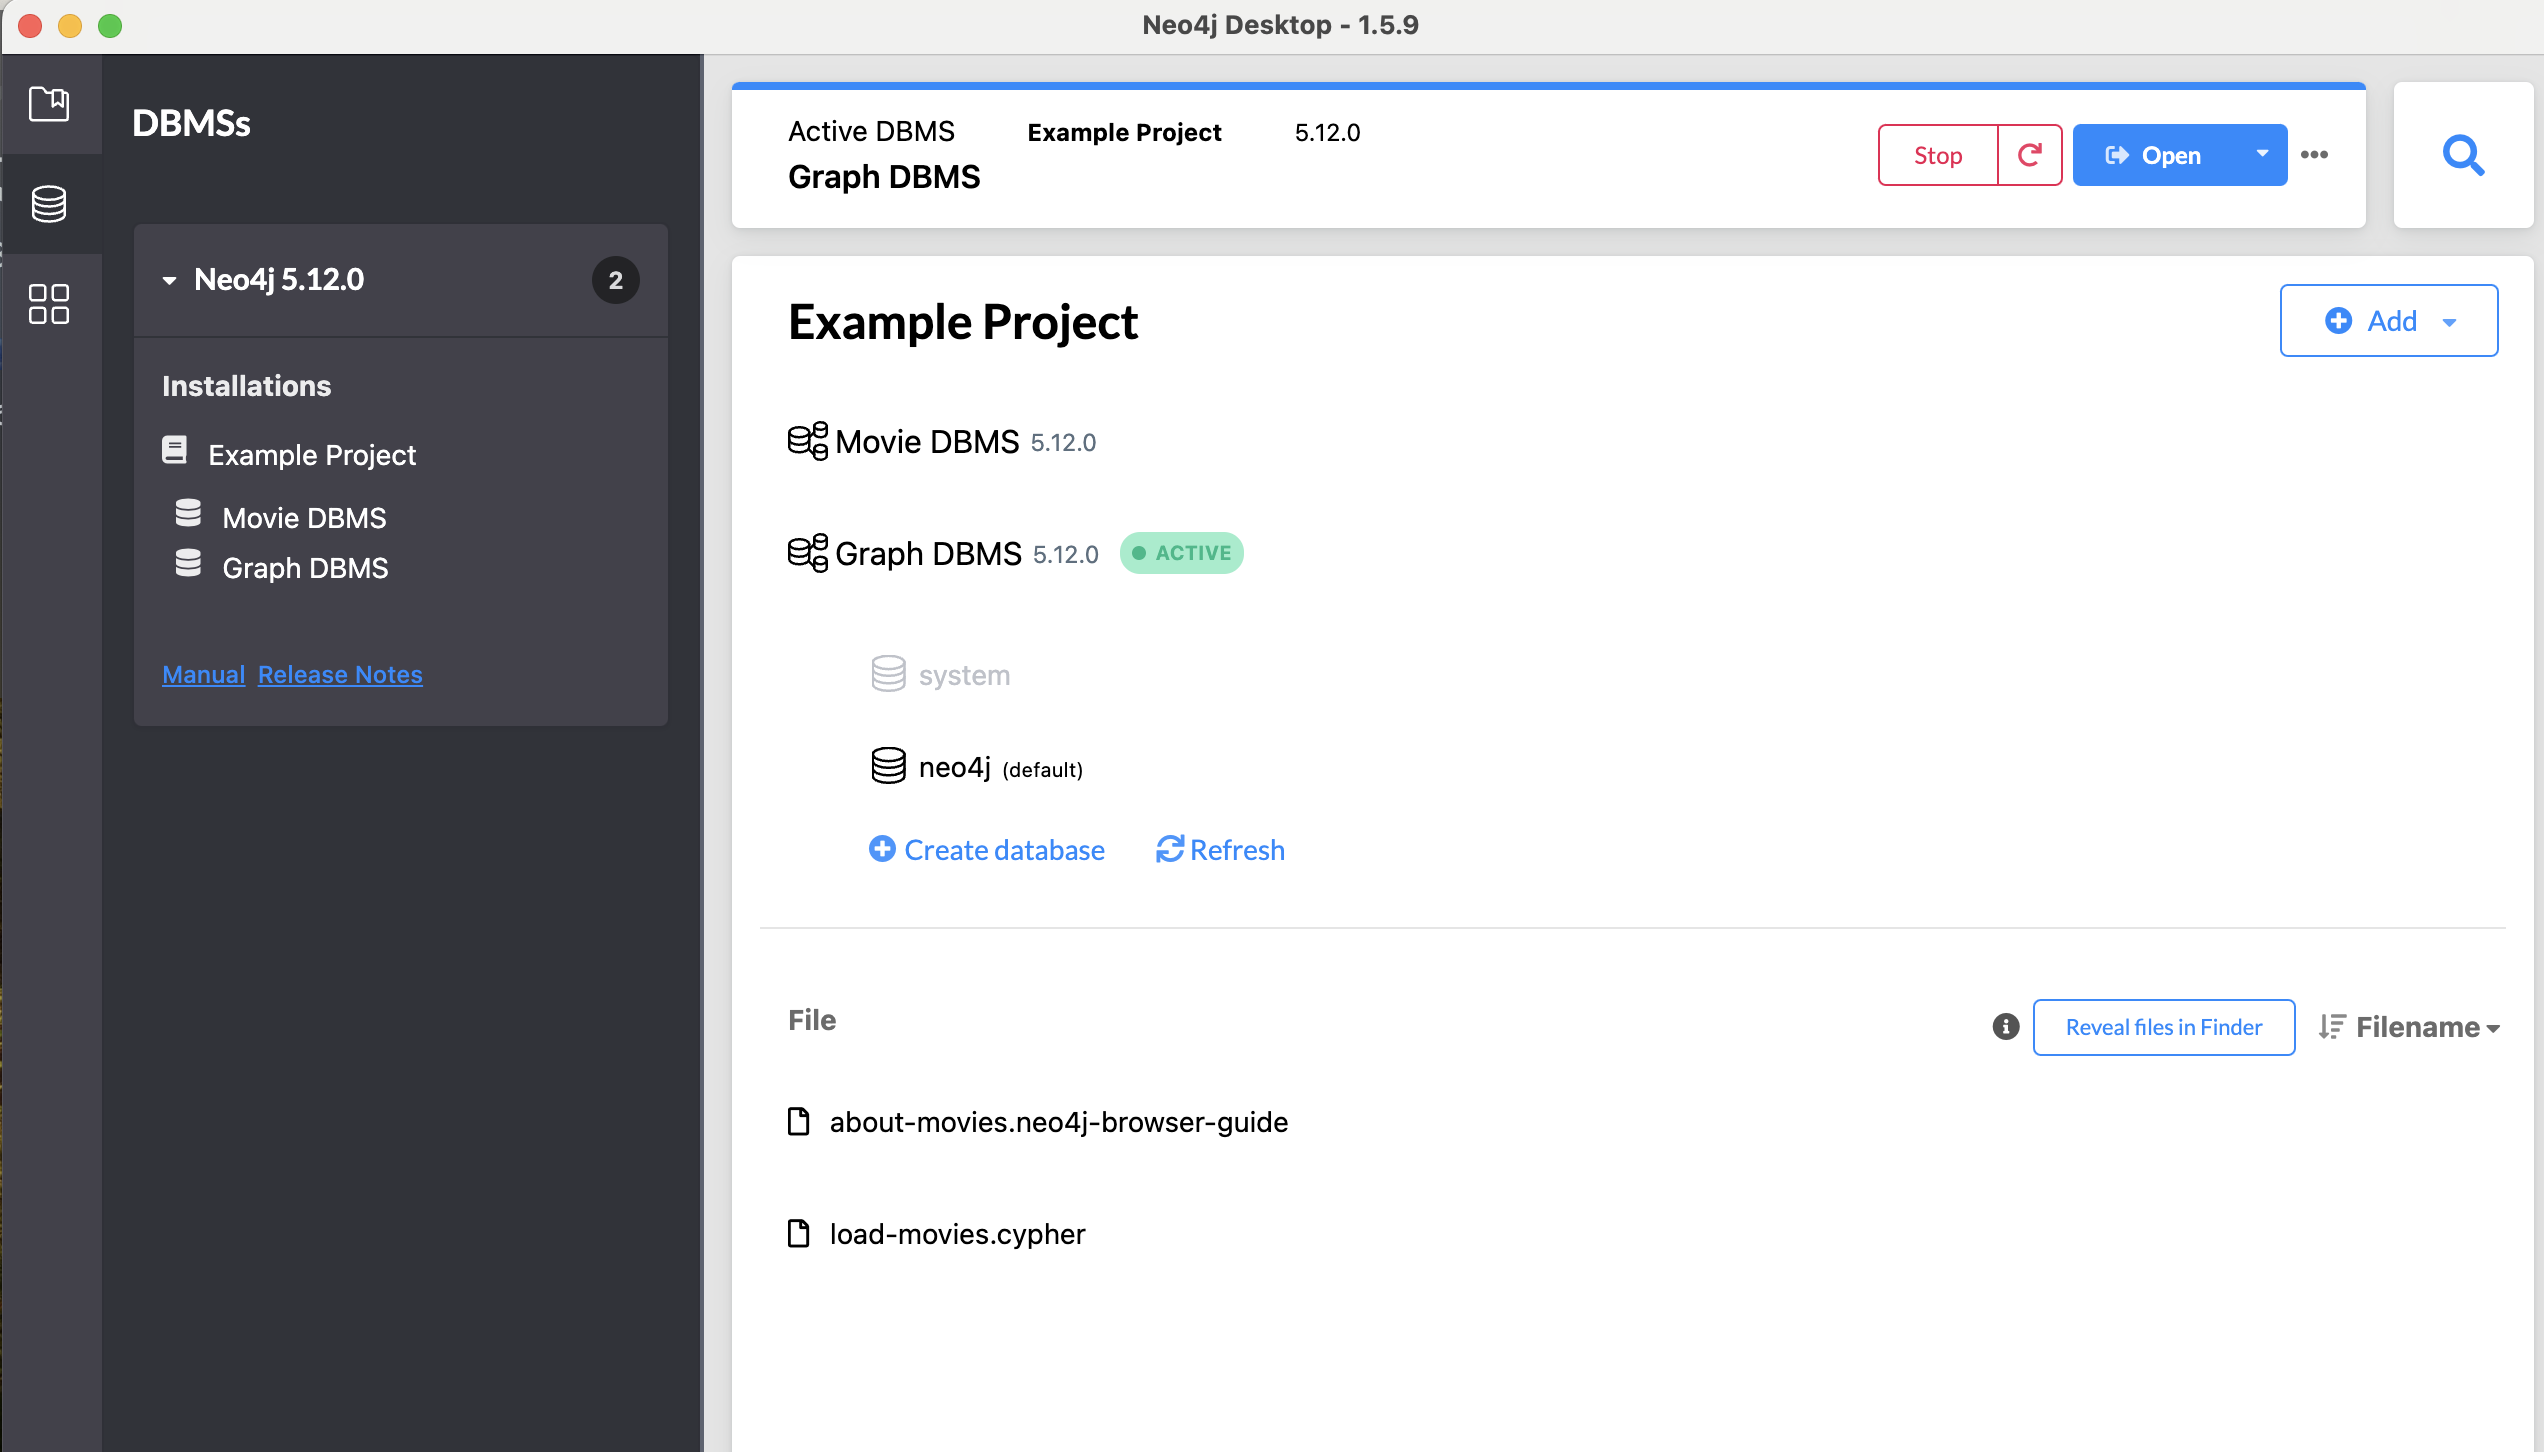

2. Открыть его в браузере 
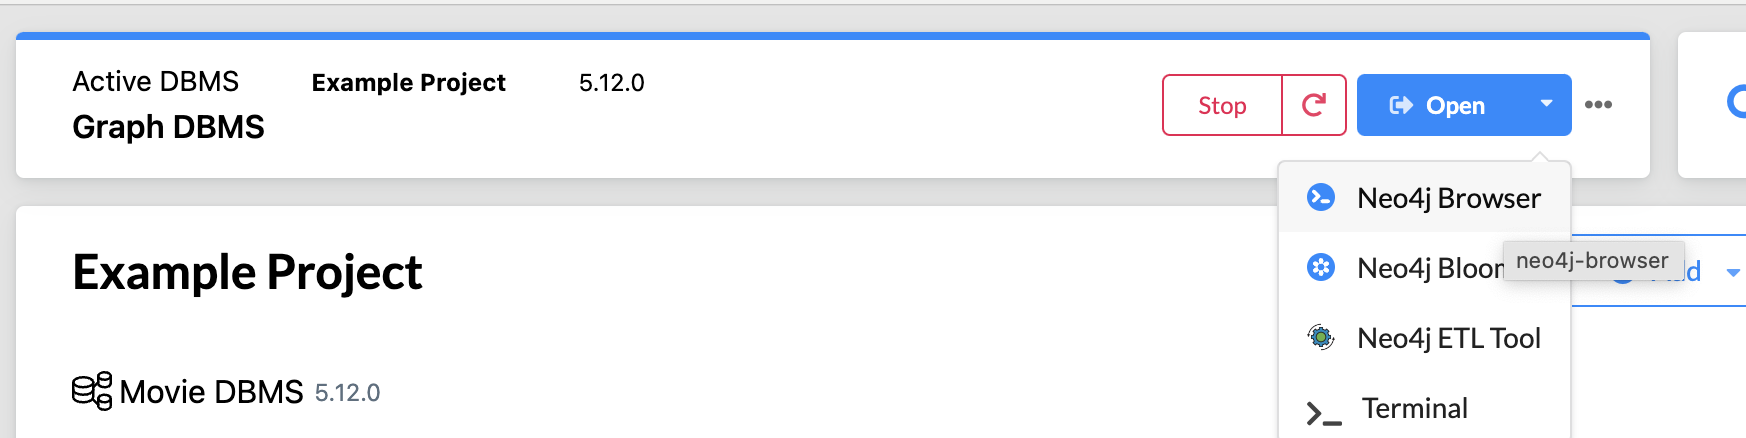

3. Выполнять запросы и смотреть данные. Примеры запросов:
- `MATCH (n) DETACH DELETE n` - Очистка существующих данных
- `MATCH (n) RETURN n LIMIT 300` - Просмотр всего графа


In [14]:
from py2neo import Graph, Node, Relationship


n_triples = 10
triplets = [[x.strip() for x in t] for t in triples_list[:n_triples] if len(t) == 3]

nodes_unique = set([])
for t in triplets:
    nodes_unique.add(t[0])
    nodes_unique.add(t[2])

node_dist = {}
for n in nodes_unique:
    node_dist[n] = Node(n, title=n)

graph = Graph("bolt://localhost:7687", auth=("neo4j", "NEO123456"))

for n in node_dist.values():
    graph.create(n)

for t in triplets:
    graph.create(Relationship(node_dist[t[0]], t[1], node_dist[t[2]]))




IMPORTANT: You are using gradio version 3.39.0, however version 4.29.0 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.39.0, however version 4.29.0 is available, please upgrade.
--------


Получается очень грасивый граф с большим количеством возможностей по просмотру

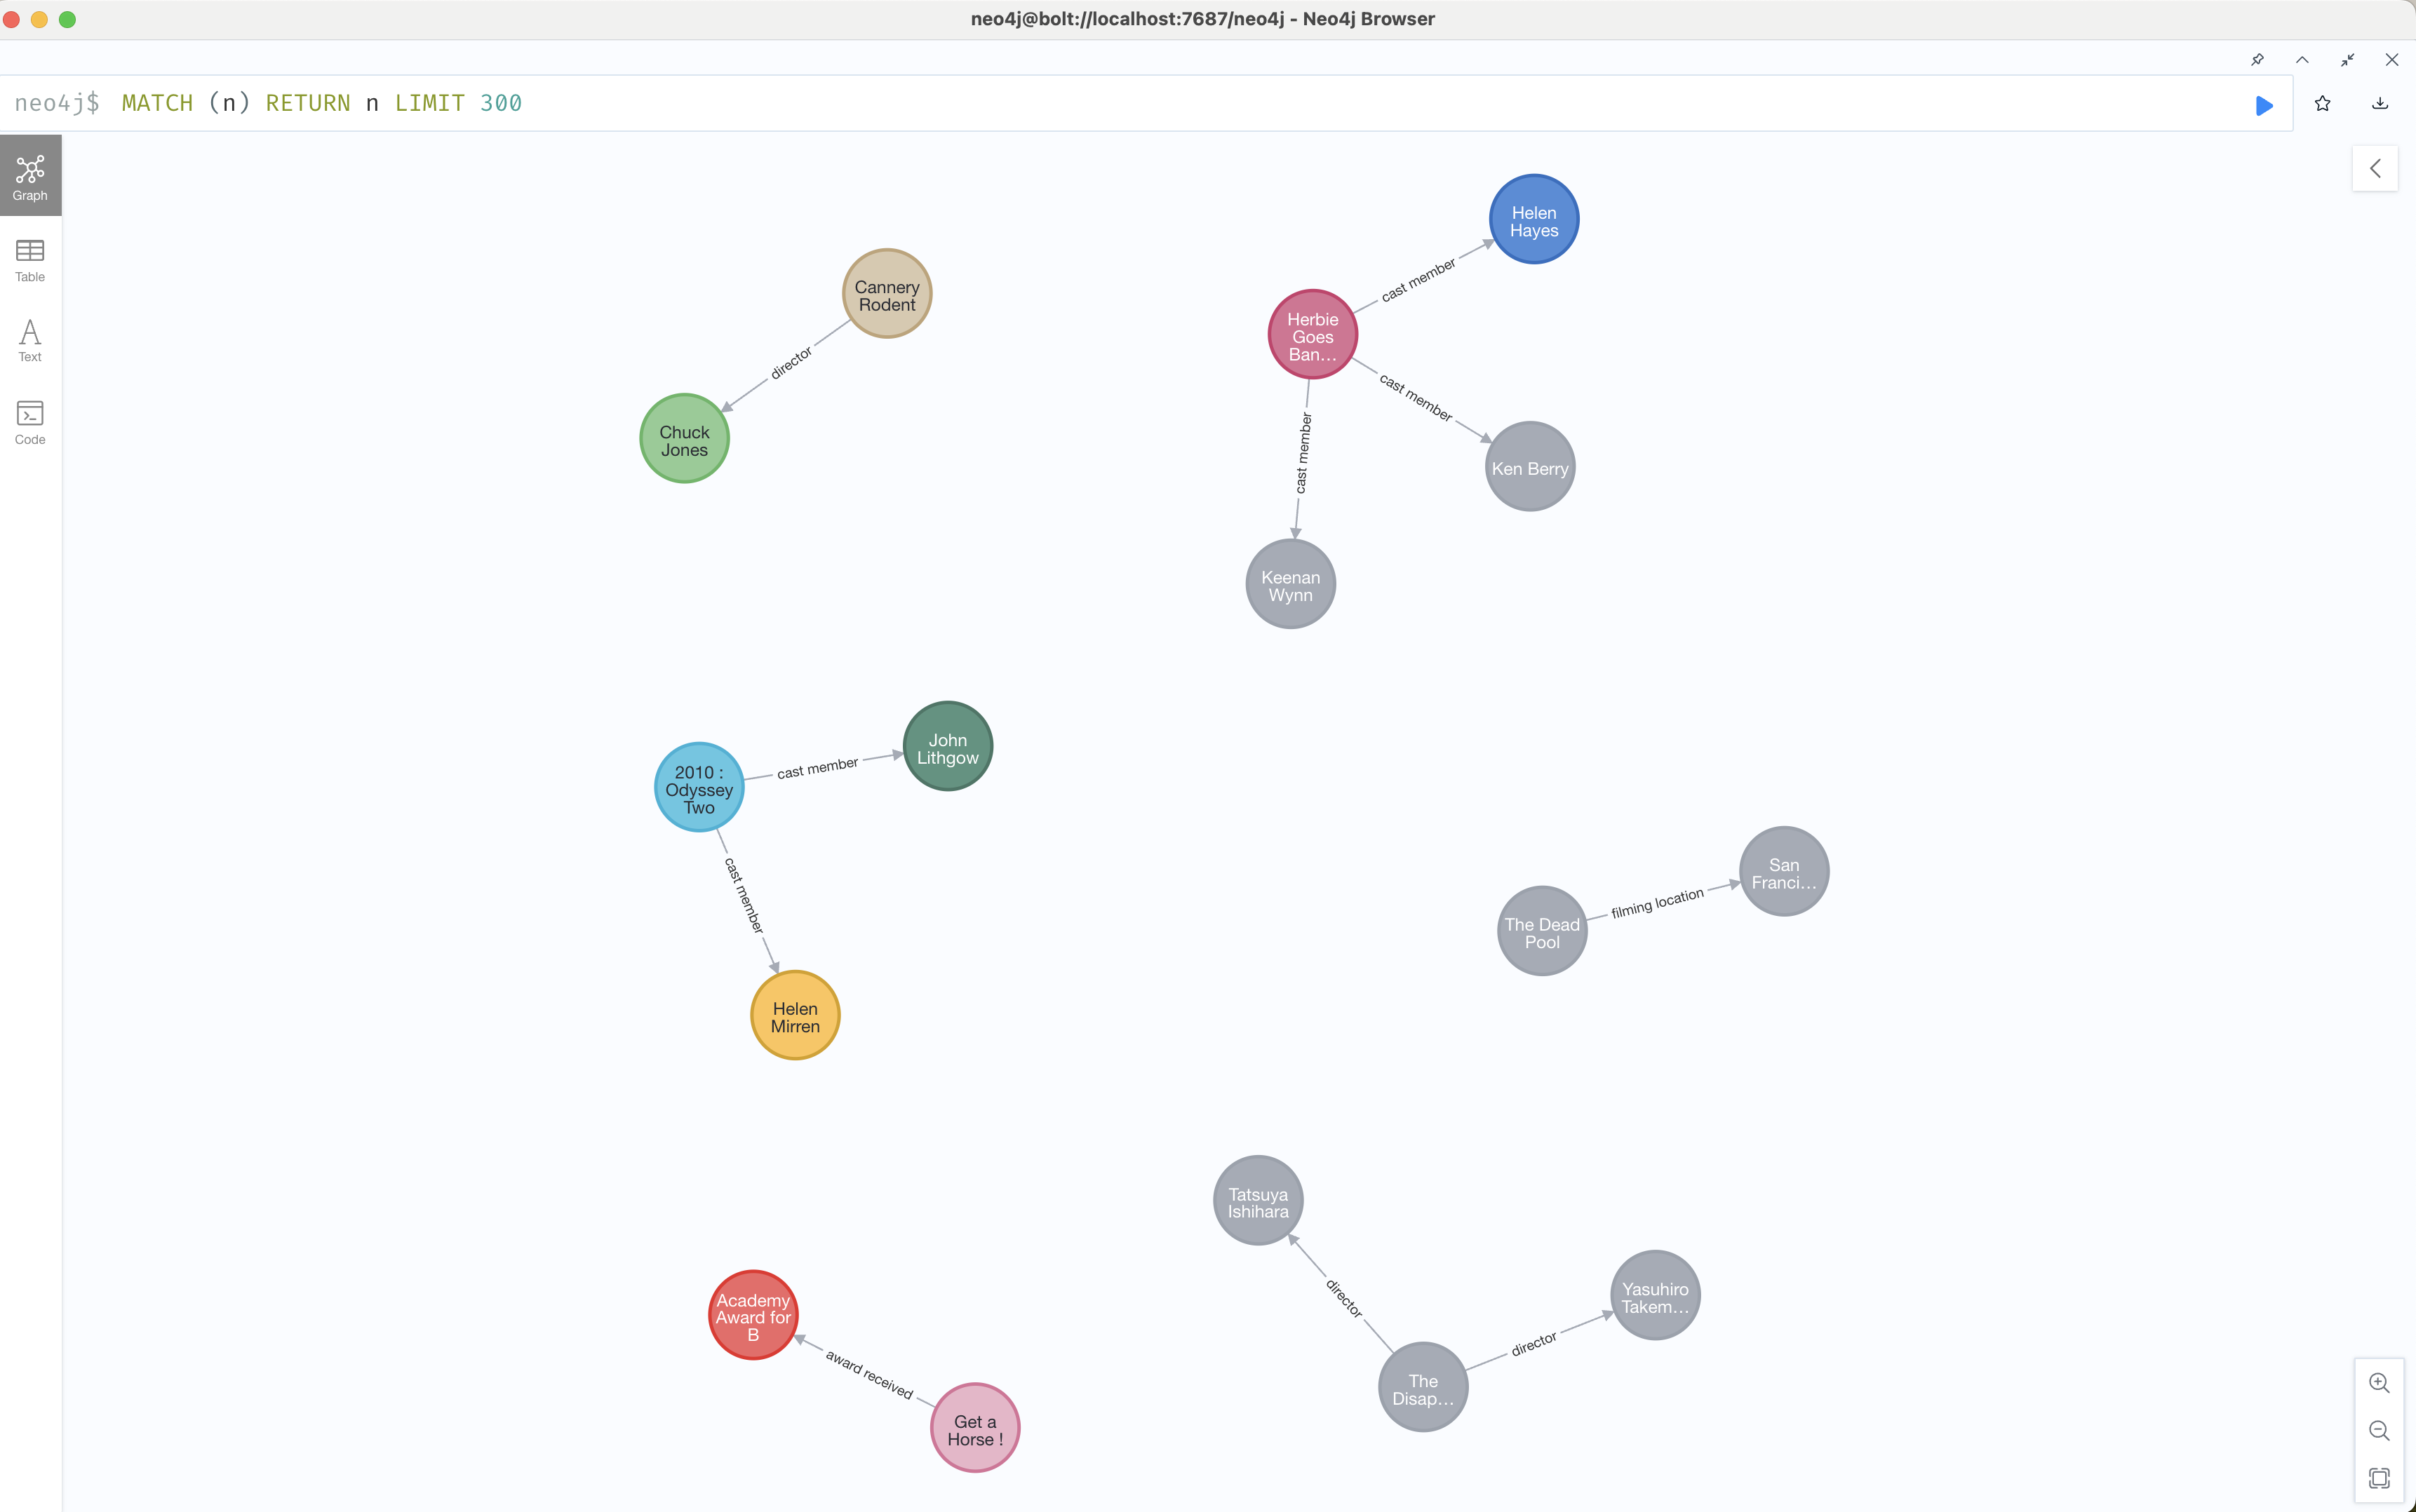